<a href="https://colab.research.google.com/github/navyadeshmukh/vision-modelx/blob/main/GANs/cGANSmnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Implementation of Conditional GAN-based handwritten image generation model trained on MNIST

#__Setup__

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms

import numpy as np
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')


Using device: cuda


# __HYPERPARAMETERS__

In [ ]:

batch_size = 128

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# Download and load the MNIST dataset
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)


100%|██████████| 9.91M/9.91M [00:00<00:00, 17.7MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 481kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.45MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.98MB/s]


 __Discriminator Network__

In [ ]:

class Discriminator(nn.Module):
    def __init__(self, img_dim, num_classes): # Added num_classes
        super(Discriminator, self).__init__()
        self.label_emb = nn.Embedding(num_classes, num_classes) # Embedding layer for labels

        self.classify = nn.Sequential(
            nn.Linear(img_dim + num_classes, 1024), # Adjusted input size to include label embedding
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),

            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),

            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),

            nn.Linear(256, 128),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),

            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, img, labels): # Added labels as input
        c = self.label_emb(labels) # Get label embedding
        x = torch.cat([img, c], 1) # Concatenate image and label embedding
        return self.classify(x)

__GENERATOR MODEL__

In [ ]:

class Generator(nn.Module):
    def __init__(self, z_dim, img_dim, num_classes): # Added num_classes
        super(Generator, self).__init__()
        self.label_emb = nn.Embedding(num_classes, num_classes) # Embedding layer for labels

        self.generate = nn.Sequential(
            nn.Linear(z_dim + num_classes, 256), # Adjusted input size to include label embedding
            nn.LeakyReLU(0.2),

            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),

            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),

            nn.Linear(1024, img_dim),
            nn.Tanh()
        )

    def forward(self, noise, labels): # Added labels as input
        c = self.label_emb(labels) # Get label embedding
        x = torch.cat([noise, c], 1) # Concatenate noise and label embedding
        return self.generate(x)

 __Initialization and Instantiating Models__

In [ ]:

noise_dim = 128
img_dim = 28 * 28
num_classes = 10 # Added num_classes

D = Discriminator(img_dim, num_classes).to(device)
G = Generator(noise_dim, img_dim, num_classes).to(device)


__Binary Cross Entropy loss and Adam optimiser__

In [ ]:
criterion = nn.BCELoss()
lr = 0.0002

D_opt = optim.Adam(D.parameters(), lr=lr)
G_opt = optim.Adam(G.parameters(), lr=lr)

__Discriminator Training Function__

In [ ]:
def train_discriminator(real_images, labels): # Added labels as input

    D_opt.zero_grad()

    real_images = real_images.view(-1, img_dim).to(device)
    real_labels = torch.ones(real_images.size(0), 1).to(device)
    real_output = D(real_images, labels.to(device)) # Passed labels to Discriminator
    D_loss_real = criterion(real_output, real_labels)

    noise = torch.randn(real_images.size(0), noise_dim).to(device) # Generate random noise
    fake_labels = torch.randint(0, num_classes, (real_images.size(0),)).to(device) # Generate random fake labels
    fake_images = G(noise, fake_labels) # Pass noise and fake labels through the Generator
    fake_output = D(fake_images.detach(), fake_labels) # Passed fake labels to Discriminator
    D_loss_fake = criterion(fake_output, torch.zeros(real_images.size(0), 1).to(device)) # Labels for fake images are 0

    # 3. Combine losses and backpropagate
    D_total_loss = D_loss_real + D_loss_fake
    D_total_loss.backward()
    D_opt.step()

    return D_total_loss.item()

__Generator Training Function__

In [ ]:

def train_generator(real_images, labels): # Added labels as input
    # Reset gradients for the Generator's optimizer
    G_opt.zero_grad()

    # Generate fake images
    noise = torch.randn(batch_size, noise_dim).to(device)
    fake_labels = torch.randint(0, num_classes, (batch_size,)).to(device) # Generate random fake labels
    # The Generator's goal is to fool the Discriminator, so we use a label of 1 (real)
    match_real_label = torch.ones(batch_size, 1).to(device)

    fake_output = G(noise, fake_labels) # Passed fake labels to Generator
    D_output = D(fake_output, fake_labels) # Passed fake labels to Discriminator
    G_loss = criterion(D_output, match_real_label)

    # Backpropagate the loss to update the Generator's weights
    G_loss.backward()
    G_opt.step()

    return G_loss.data.item()

__Main Training Loop__

In [ ]:
def train(num_epochs):

    D.train()
    G.train()

    avg_d_losses = []
    avg_g_losses = []

    for epoch in range(num_epochs):
        D_loss = []
        G_loss = []

        for i, (x, y) in enumerate(train_loader): # Added y for labels

            D_loss.append(train_discriminator(x, y)) # Passed labels to train_discriminator
            G_loss.append(train_generator(x, y)) # Passed labels to train_generator

        avg_d_loss = torch.mean(torch.FloatTensor(D_loss))
        avg_g_loss = torch.mean(torch.FloatTensor(G_loss))
        avg_d_losses.append(avg_d_loss)
        avg_g_losses.append(avg_g_loss)


        if (epoch) % 10 == 0:
            print(f'Epoch {epoch} ~> Discriminator_avg_loss: {avg_d_loss: .4f}, Generator_avg_loss: {avg_g_loss: .4f}')

    return avg_d_losses, avg_g_losses

 __Run Training__

In [ ]:
avg_d_losses, avg_g_losses = train(200)


Epoch 0 ~> Discriminator_avg_loss:  1.0835, Generator_avg_loss:  1.6612
Epoch 10 ~> Discriminator_avg_loss:  0.4205, Generator_avg_loss:  3.4300
Epoch 20 ~> Discriminator_avg_loss:  0.8005, Generator_avg_loss:  1.9105
Epoch 30 ~> Discriminator_avg_loss:  0.9515, Generator_avg_loss:  1.5538
Epoch 40 ~> Discriminator_avg_loss:  1.1023, Generator_avg_loss:  1.2175
Epoch 50 ~> Discriminator_avg_loss:  1.1670, Generator_avg_loss:  1.0919
Epoch 60 ~> Discriminator_avg_loss:  1.1875, Generator_avg_loss:  1.0466
Epoch 70 ~> Discriminator_avg_loss:  1.2217, Generator_avg_loss:  0.9888
Epoch 80 ~> Discriminator_avg_loss:  1.2347, Generator_avg_loss:  0.9665
Epoch 90 ~> Discriminator_avg_loss:  1.2702, Generator_avg_loss:  0.9168
Epoch 100 ~> Discriminator_avg_loss:  1.2496, Generator_avg_loss:  0.9262
Epoch 110 ~> Discriminator_avg_loss:  1.2807, Generator_avg_loss:  0.8964
Epoch 120 ~> Discriminator_avg_loss:  1.2771, Generator_avg_loss:  0.8843
Epoch 130 ~> Discriminator_avg_loss:  1.3000, Gen

__Save Models__

In [ ]:
torch.save({
    'model_state_dict': D.state_dict(),
    'optimizer_state_dict': D_opt.state_dict(),
}, 'D.pt')

torch.save({
    'model_state_dict': G.state_dict(),
    'optimizer_state_dict': G_opt.state_dict(),
}, 'G.pt')

 __Plotting Losses__

In [ ]:
def plot_losses(avg_D_losses, avg_G_losses, num_epochs):
    epochs = range(1, len(avg_D_losses) + 1) # Changed to use length of losses list
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, avg_D_losses, label='Average Discriminator Loss')
    plt.plot(epochs, avg_G_losses, label='Average Generator Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Average Discriminator and Generator Losses over Epochs')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_losses(avg_d_losses, avg_g_losses, 200) # Pass the actual number of epochs trained

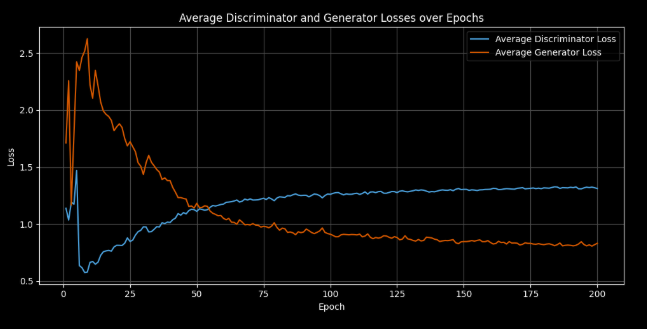

__Display Generated Samples__

In [ ]:
def display_generated_samples(generator, noise_dim, num_samples=49):

    generator.eval()
    with torch.no_grad():
        # Generate a fixed set of labels for consistent output display
        labels = torch.tensor([i // int(np.sqrt(num_samples)) for i in range(num_samples)]).to(device) # Generate labels 0-9 repeatedly
        noise = torch.randn(num_samples, noise_dim).to(device)
        generated_images = generator(noise, labels).view(num_samples, 1, 28, 28).cpu() # Pass labels to generator

    fig, axes = plt.subplots(int(np.sqrt(num_samples)), int(np.sqrt(num_samples)), figsize=(7, 7))
    for i, ax in enumerate(axes.flat):
        ax.imshow(generated_images[i].squeeze(), cmap='gray')
        ax.axis('off')
    plt.tight_layout()
    plt.show()

display_generated_samples(G, noise_dim, 36)

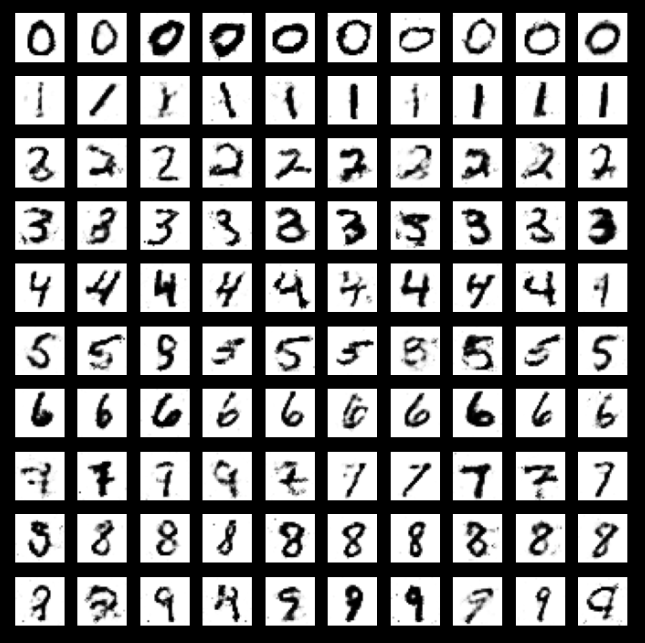